`K. Ong | Fall 2018`

This notebook contains the workflow used to analyze survey data as part of the Deloitte NomComm project. We use a toy dataset of Amazon product reviews of items in the Grocery catgegory which be downloaded from [here](http://jmcauley.ucsd.edu/data/amazon/).

The workflow runs as follows:
- Preprocessing: tokenization and phrase detection
- Topic Modelling: vectorization, grid search, model selection
- Summarization: word/phrase counts 

Note that we call many functions from our helper files, which can be found [here](helpers).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time 

import pandas as pd 
import numpy as np
import statistics
import re
import string
import collections
import matplotlib.pyplot as plt

import sys
path_to_helpers = 'helpers/'
sys.path.insert(0, path_to_helpers)
from helper_prep import * # contains preprocessing helper functions
from helper_base import * # contains basic jupyter helper functions


In [2]:
filename = '../reviews_Grocery_and_Gourmet_Food_5.json.gz'
raw = getDF(filename)

In [3]:
raw.shape

(151254, 9)

In [4]:
display_all(raw.head())

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"


# Some basic EDA

In [5]:
print('Number of Products: ', raw.asin.nunique())
print('Number of Reviewers: ', raw.reviewerID.nunique())
print('Average Rating: ', round(raw.overall.mean(),2))
print('Median Rating: ', statistics.median(raw.overall))

Number of Products:  8713
Number of Reviewers:  14681
Average Rating:  4.24
Median Rating:  5.0


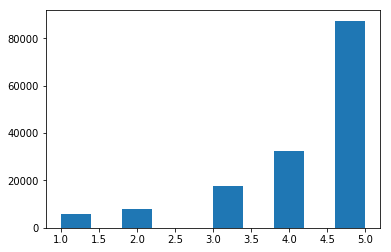

In [6]:
import matplotlib.pyplot as plt
plt.hist(raw.overall); plt.show()

Notice that ratings are skewed positive. ([Here](https://hbr.org/2018/03/online-reviews-are-biased-heres-how-to-fix-th)'s an interesting article about this.)

Let's look at a breakdown of reviews over time: 

In [7]:
raw['review_year'] = raw.reviewTime.apply(lambda x: int(x.split(',')[1].strip()))

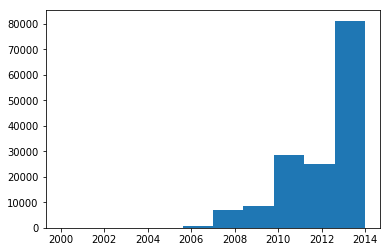

In [8]:
plt.hist(raw.review_year); plt.show()

In [9]:
raw.groupby('review_year').size()

review_year
2000        1
2003        1
2004       11
2005       37
2006      598
2007     1826
2008     5330
2009     8417
2010     8443
2011    20059
2012    25235
2013    51899
2014    29397
dtype: int64

Notice that number of reviews grows exponentially with time. Since this notebook is purely for illustrative purposes, let's reduce the data volume by selecting reviews only from 2013.

In [10]:
df = raw[raw.review_year == 2013]; df.shape

(51899, 10)

# Preprocessing

Notice that our dataset contains two text fields: `reviewText`, which contains the body of the review, and `summary`, which contains the review title. Let's agree to use the former based on the hypothesis that more data leads to more cohesive topics.

Below, we call the function `prep_dataset()`, which lowers, replaces common word truncations, and removes all special characters and performs lemmatization.

In [11]:
df, df_tokens, df_lemmas = prep_dataset(df, 'reviewText', 'reviews_clean')

Dimension of Text:  (51894, 11)
Number of Tokens:  4456211
Number of Lemmas:  4457180



In [12]:
display_all(df[:1])

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_year,reviews_clean
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013",2013,just another flavor of kit kat but the taste i...


# A quick look at frequencies

In [13]:
tokens_nonstop = [i for i in df_tokens if i not in en_stopwords]
lemmas_nonstop = [i for i in df_lemmas if i not in en_stopwords]

In [14]:
tokens_counter = collections.Counter(tokens_nonstop)
sorted(tokens_counter.items(), key=lambda x: -x[1])[:10]

[('like', 28310),
 ('good', 23512),
 ('taste', 21212),
 ('flavor', 19065),
 ('coffee', 16748),
 ('one', 15956),
 ('tea', 15880),
 ('great', 15632),
 ('would', 13322),
 ('product', 11617)]

In [15]:
lemmas_counter = collections.Counter(lemmas_nonstop)
sorted(lemmas_counter.items(), key=lambda x: -x[1])[:10]

[('like', 31418),
 ('taste', 30234),
 ('flavor', 24603),
 ('good', 23823),
 ('use', 21156),
 ('make', 19980),
 ('coffee', 17749),
 ('tea', 17682),
 ('one', 17478),
 ('great', 15632)]

Notice that lemmatization significantly changes the distribution of tokens - the top token 'like' occurs 11% more times when taking into account its morphological variants.

# Phrase detection

Below we use `find_ngrams()` to perform phrase detection using two approaches:
- Parts-of-speech, which filters for appropriate POS combinations as discussed [here](https://medium.com/@nicharuch/collocations-identifying-phrases-that-act-like-individual-words-in-nlp-f58a93a2f84a).
- Pointwise mutual information (PMI) score with frequency filter

For the PMI approach, our function takes in arguments for `n`, the number of occurrences above which to consider, and `pct`, the PMI score percentile for cut off. We generally found that this approach was less effective for our corpus, but it is included here for illustrative purposes. Note that by default, `find_ngrams()` uses the POS-approach only.

In [16]:
bigrams_pos, trigrams_pos, bigrams_pmi, trigrams_pmi = find_ngrams(df_lemmas, n=20, pct=95, pmi_flag=True) 

In [17]:
bigrams_pos[:5]

,bigram,freq
11370,"(peanut, butter)",1970
38,"(green, tea)",1770
9086,"(coconut, oil)",1686
1817,"(grocery, store)",1212
10406,"(tea, bag)",1160


In [18]:
trigrams_pos[:5]

,trigram,freq
7736,"(local, grocery, store)",253
19558,"(pu, erh, tea)",216
257332,"(whole, grain, pasta)",176
87028,"(taste, pretty, good)",171
66062,"(high, fructose, corn)",165


In [19]:
bigrams_pmi[:5]

,bigram,PMI
0,"(567, 557)",17.765772
1,"(n/a, 214)",17.695382
2,"(557, 575)",17.628268
3,"(109, 151)",17.624993
4,"(368, 567)",17.564138


In [20]:
trigrams_pmi[:5]

,trigram,PMI
0,"(567, 557, 575)",35.394040
1,"(368, 567, 557)",35.329910
2,"(371, 368, 567)",35.128276
3,"(490, 371, 368)",34.651838
4,"(534, 490, 371)",34.651838


We can see that the parts-of-speech approach is more effective at filtering out nonsensensical collocations. In the case of these reviews, alot of numerical collocations are picked up (from reviews such as the following), which could in practice be overcome by filtering out tokens that are numeric. However, for the purposes of this demo, let's proceed with the n-grams identified via the first approach.

In [21]:
df[df.reviewText.str.contains('567')][:1].reviewText.values

array(['UPDATE INFO AS OF 1/29/2014List Price: $20.94Price: $4.91 ($0.02 / oz)You Save: $16.03 (77%)$0.02 an oz for 16oz in a pound will be only $0.32 a bag not $4.91 as claimed by the seller. Flax seeds sells never sells for $20.94 a bag as claimed by the seller. It seems that the seller keeps changing the sale numbers in order to sell a product. Arrowhead is an excellent brand with many great organic products where others fail to produce in organic form but this approach is just misleading and not necessary at all.*****************************************************************************************************************************ORIGINAL REVIEW 10/11/2013Seller claims;List Price: $40.61Price: $8.24 ($0.04/oz) & FREE Shipping on orders over $25You Save: $32.37 (80%)That is misleading. No flax sells for $40 a pound. At $8.24 a pound it is 824/16=51.5 infact something like more than $0.51 cents an oz not $0.04 an oz. Arrowhead is a good brand but the seller is misrepresenting th

We used a frequency filter to decide which bigrams and trigrams to include as "phrases". These thresholds should be manually updated each time by looking at whether the phrases at the lower end of the frequency range make sense and are sufficiently cohesive. For instance, consider the difference in phrases using a threshold of 100 vs. 90 shown below:

In [22]:
bigrams_pos[bigrams_pos.freq>100].tail(10)

,bigram,freq
51666,"(peppermint, tea)",102
8561,"(wonderful, flavor)",102
57151,"(roast, garlic)",102
37205,"(caramel, flavor)",101
25226,"(start, use)",101
9085,"(organic, coconut)",101
36441,"(something, sweet)",101
70733,"(better, taste)",101
15481,"(chicken, broth)",101
2102,"(great, quality)",101


In [23]:
bigrams_pos[bigrams_pos.freq>90].tail(10)

,bigram,freq
2361,"(paper, filter)",92
22830,"(kcup, brewer)",92
16846,"(mac, n)",92
60400,"(whole, thing)",92
2219,"(mountain, coffee)",91
20645,"(recipe, call)",91
87564,"(mill, product)",91
302720,"(fog, chaser)",91
8292,"(sweet, flavor)",91
1139,"(great, addition)",91


In [24]:
bigrams_filtered = bigrams_pos[bigrams_pos.freq>100].bigram.values.tolist()
trigrams_filtered = trigrams_pos[trigrams_pos.freq>55].trigram.values.tolist()
print('Number of Bigrams: ', len(bigrams_filtered))
print('Number of Trigrams: ', len(trigrams_filtered))

Number of Bigrams:  389
Number of Trigrams:  50


Finally, we use `regram()` to replace all instances of the collocations in the text with underscored versions, such that, for example, "it has a wonderful flavor" becomes "it has a wonderful_flavor". Since we previously removed all special characters in the text, introducting underscores will allow us to retokenize the text on spaces and retain these collocations as single tokens.

In [25]:
df = regram(df, 'reviews_lemmas', 'reviews_regram', bigrams_filtered, trigrams_filtered)

We now write out the processed text to be used for topic modelling, with a timestamp for improved version control.

In [26]:
now = time.strftime('%Y%m%d_%H%M')
df.to_csv('../df_output_%s.csv' %now, index = False)